<a href="https://colab.research.google.com/github/spencer18001/machine-learning-zoomcamp/blob/main/04/hw_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pipenv
!wget -O bank+marketing.zip wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip && unzip bank.zip 'bank-full.csv' -d .

In [ ]:
!pipenv --version #Q1

In [ ]:
!pipenv install sklearn==1.5.2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [3]:
df_path = "bank-full.csv"
df = pd.read_csv(df_path, sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.shape

(45211, 17)

In [5]:
df = df[['age', 'job', 'marital', 'education', 'balance',
         'housing', 'contact', 'day', 'month', 'duration',
         'campaign', 'pdays', 'previous', 'poutcome', 'y']]
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [6]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
balance,int64
housing,object
contact,object
day,int64
month,object
duration,int64


In [7]:
df.isnull().sum() # no missing values

,0
age,0
job,0
marital,0
education,0
balance,0
housing,0
contact,0
day,0
month,0
duration,0


In [8]:
df.iloc[:, -1].value_counts() # check distinct labels

,count
y,
no,39922
yes,5289


In [9]:
# replace the values yes/no with 1/0
# https://stackoverflow.com/questions/52395179/change-dtype-of-specific-columns-with-iloc
df[df.columns[-1]] = df[df.columns[-1]].map({"yes": 1, "no": 0}).astype(int)
df.iloc[:, -1]

,y
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


In [10]:
def data_split(df, random_state):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)
    return df_train, df_val, df_test

In [11]:
df_train, df_val, df_test = data_split(df, random_state=1)
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

In [12]:
num_cols = df_train.iloc[:, :-1].select_dtypes(include=['int64']).columns
num_scores = []
for col in num_cols:
    auc = roc_auc_score(df_train.iloc[:, -1], df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train.iloc[:, -1], -df_train[col])

    num_scores.append(auc)

num_cols[np.argmax(num_scores)], dict(zip(num_cols, num_scores)) # Q1

('duration',
 {'age': 0.512185717527344,
  'balance': 0.5888313805382317,
  'day': 0.525957882383908,
  'duration': 0.8147002759670778,
  'campaign': 0.5714543015682159,
  'pdays': 0.5901276247352144,
  'previous': 0.5985653242764153})

In [13]:
def one_hot_encode(df, dv, train):
    feature_dict = df.iloc[:, :-1].to_dict(orient='records')
    if train == True:
        X = dv.fit_transform(feature_dict)
    else:
        X = dv.transform(feature_dict)
    return X

In [14]:
def logistic_regression_fit(df, C, dv):
    X = one_hot_encode(df, dv, train=True)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, df.iloc[:, -1].values)
    return model

In [15]:
def logistic_regression_predict(model, df, dv):
    X = one_hot_encode(df, dv, train=False)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [16]:
dv = DictVectorizer(sparse=False)
model = logistic_regression_fit(df_train, C=1.0, dv=dv)
y_pred = logistic_regression_predict(model, df_val, dv=dv)
auc = roc_auc_score(df_val.iloc[:, -1], y_pred)
round(auc, 3) # Q2

0.9

In [17]:
def calculate_scores(y_truth, y_pred):
    scores = []
    thresholds = np.arange(0.0, 1.01, 0.01)
    for t in thresholds:
        actual_positive = (y_truth == 1)
        actual_negative = (y_truth == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1_score'] = (2 * df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
    return df_scores

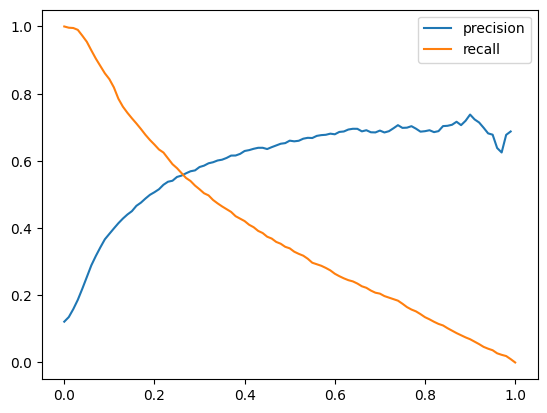

In [18]:
df_scores = calculate_scores(df_val.iloc[:, -1], y_pred)

plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.legend()

In [19]:
min_idx = (df_scores.precision - df_scores.recall).abs().idxmin()
df_scores.loc[min_idx].threshold # Q3

0.26

In [20]:
df_scores.loc[df_scores.f1_score.idxmax()].threshold # Q4

0.22

In [21]:
def kfold_run(n_splits, df, C):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        dv = DictVectorizer(sparse=False)
        model = logistic_regression_fit(df_train, C=C, dv=dv)
        y_pred = logistic_regression_predict(model, df_val, dv=dv)

        auc = roc_auc_score(df_val.iloc[:, -1], y_pred)
        scores.append(auc)
    return scores

In [22]:
scores = kfold_run(5, df_full_train, C=1.0)
np.std(scores), scores # Q5

(0.004481254676436143,
 [0.908669175844581,
  0.9048462858577991,
  0.9125790131406669,
  0.9020334720115258,
  0.9002132726225991])

In [23]:
C_list = [0.000001, 0.001, 1]
mean_scores = []
std_scores = []
for C in tqdm(C_list):
    scores = kfold_run(5, df, C=C)
    mean_scores.append(round(np.mean(scores), 3))
    std_scores.append(round(np.std(scores), 3))

C_list[np.argmax(mean_scores)], dict(zip(C_list, zip(mean_scores, std_scores))) # Q6

  0%|          | 0/3 [00:00<?, ?it/s]

(1, {1e-06: (0.705, 0.011), 0.001: (0.868, 0.006), 1: (0.906, 0.004)})